<a href="https://colab.research.google.com/github/yashudarling/DOG-DETECTION-SPY/blob/main/AGGRESSIVE_DOG_DETECTION_SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 15897, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15897 (delta 4), reused 16 (delta 4), pack-reused 15880
Receiving objects: 100% (15897/15897), 14.57 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (10903/10903), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [3]:
!unzip -q ../dog\ detection.v3i.yolov5pytorch.zip -d ../

In [4]:
%cd /content/yolov5

/content/yolov5


In [5]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat ../data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['chasing dog', 'child', 'dog biting child', 'dog', 'running child']

roboflow:
  workspace: dog-bite-detection
  project: dog-detection-is87r
  version: 3
  license: CC BY 4.0
  url: https://universe.roboflow.com/dog-bite-detection/dog-detection-is87r/dataset/3

In [6]:
# define number of classes based on YAML
import yaml
with open(".." + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [8]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 5  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [10]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data ../data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-08-10 20:53:52.454699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 20:53:53.311639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entit

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [11]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

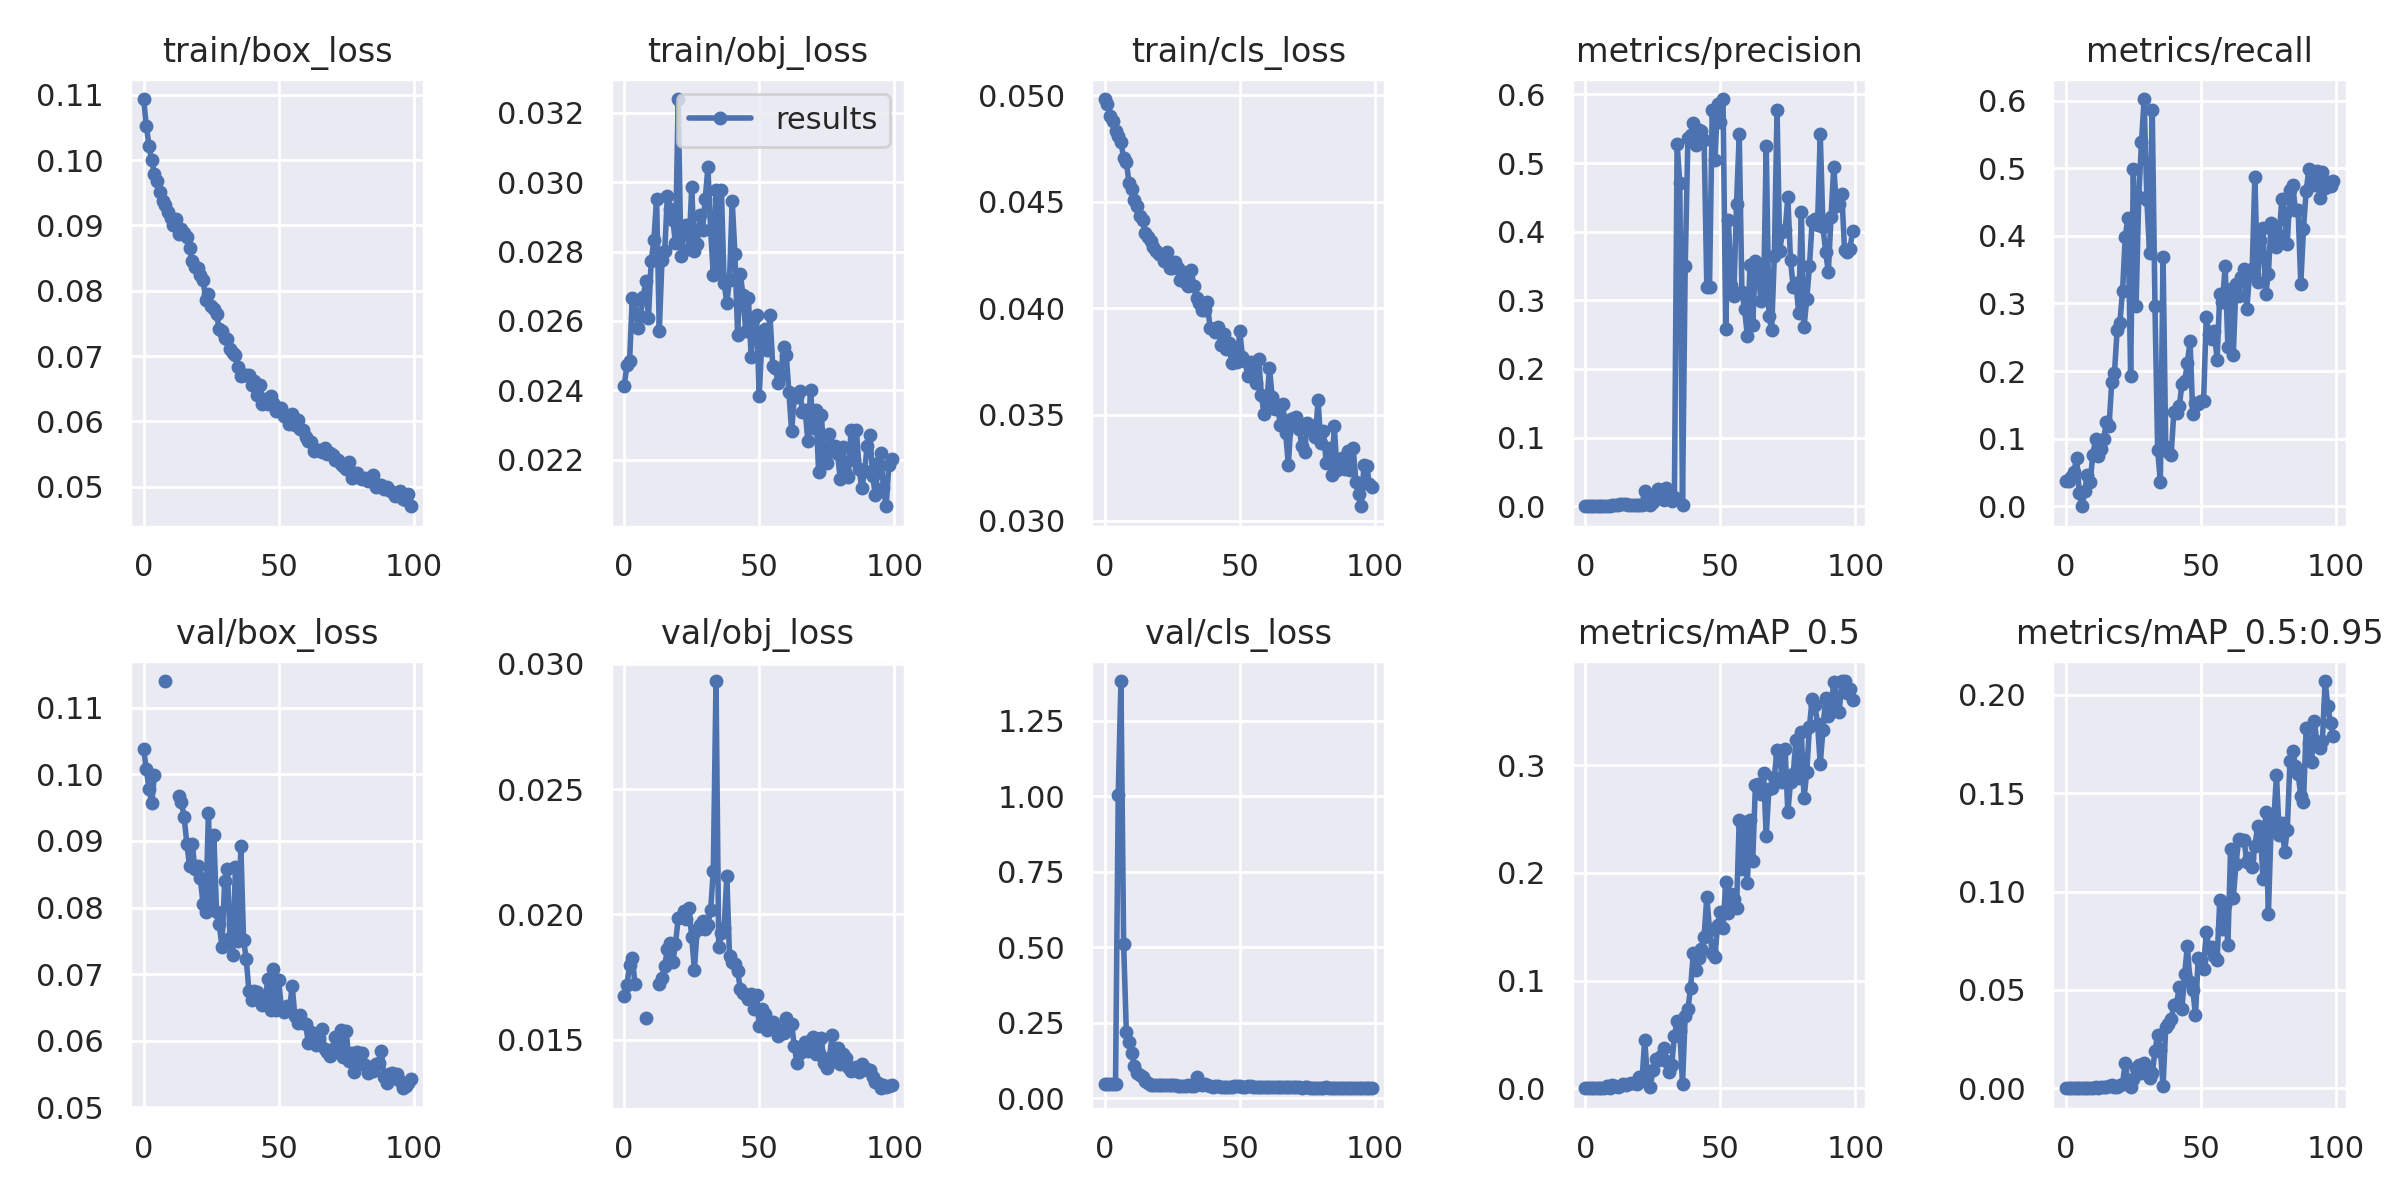

In [12]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


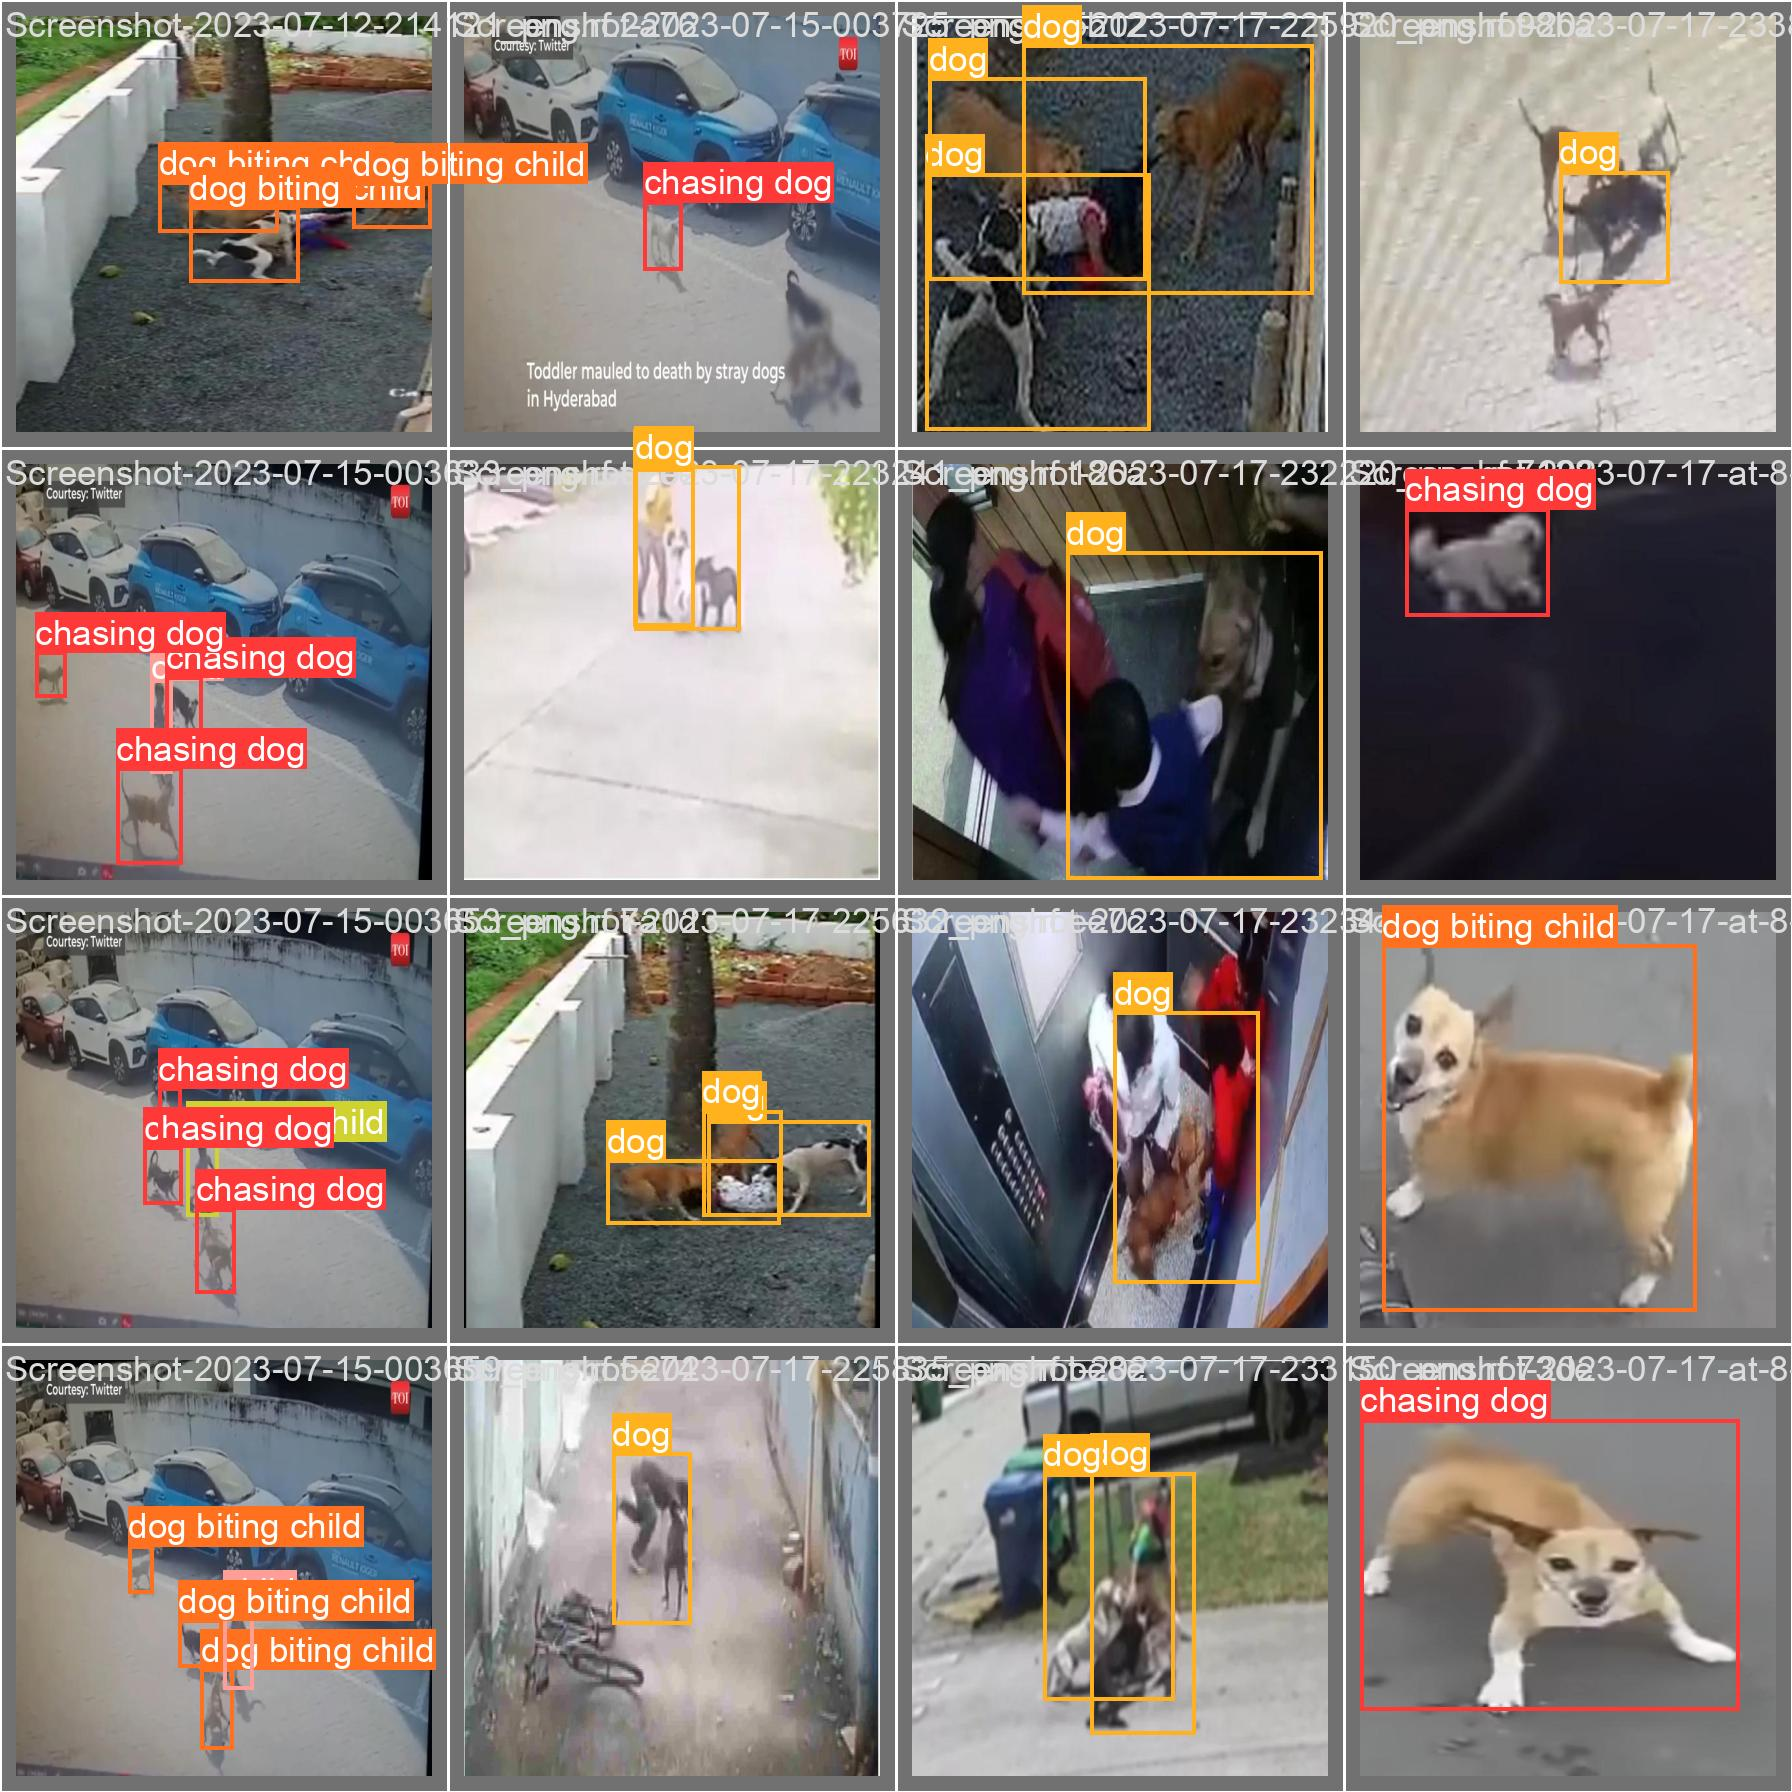

In [13]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


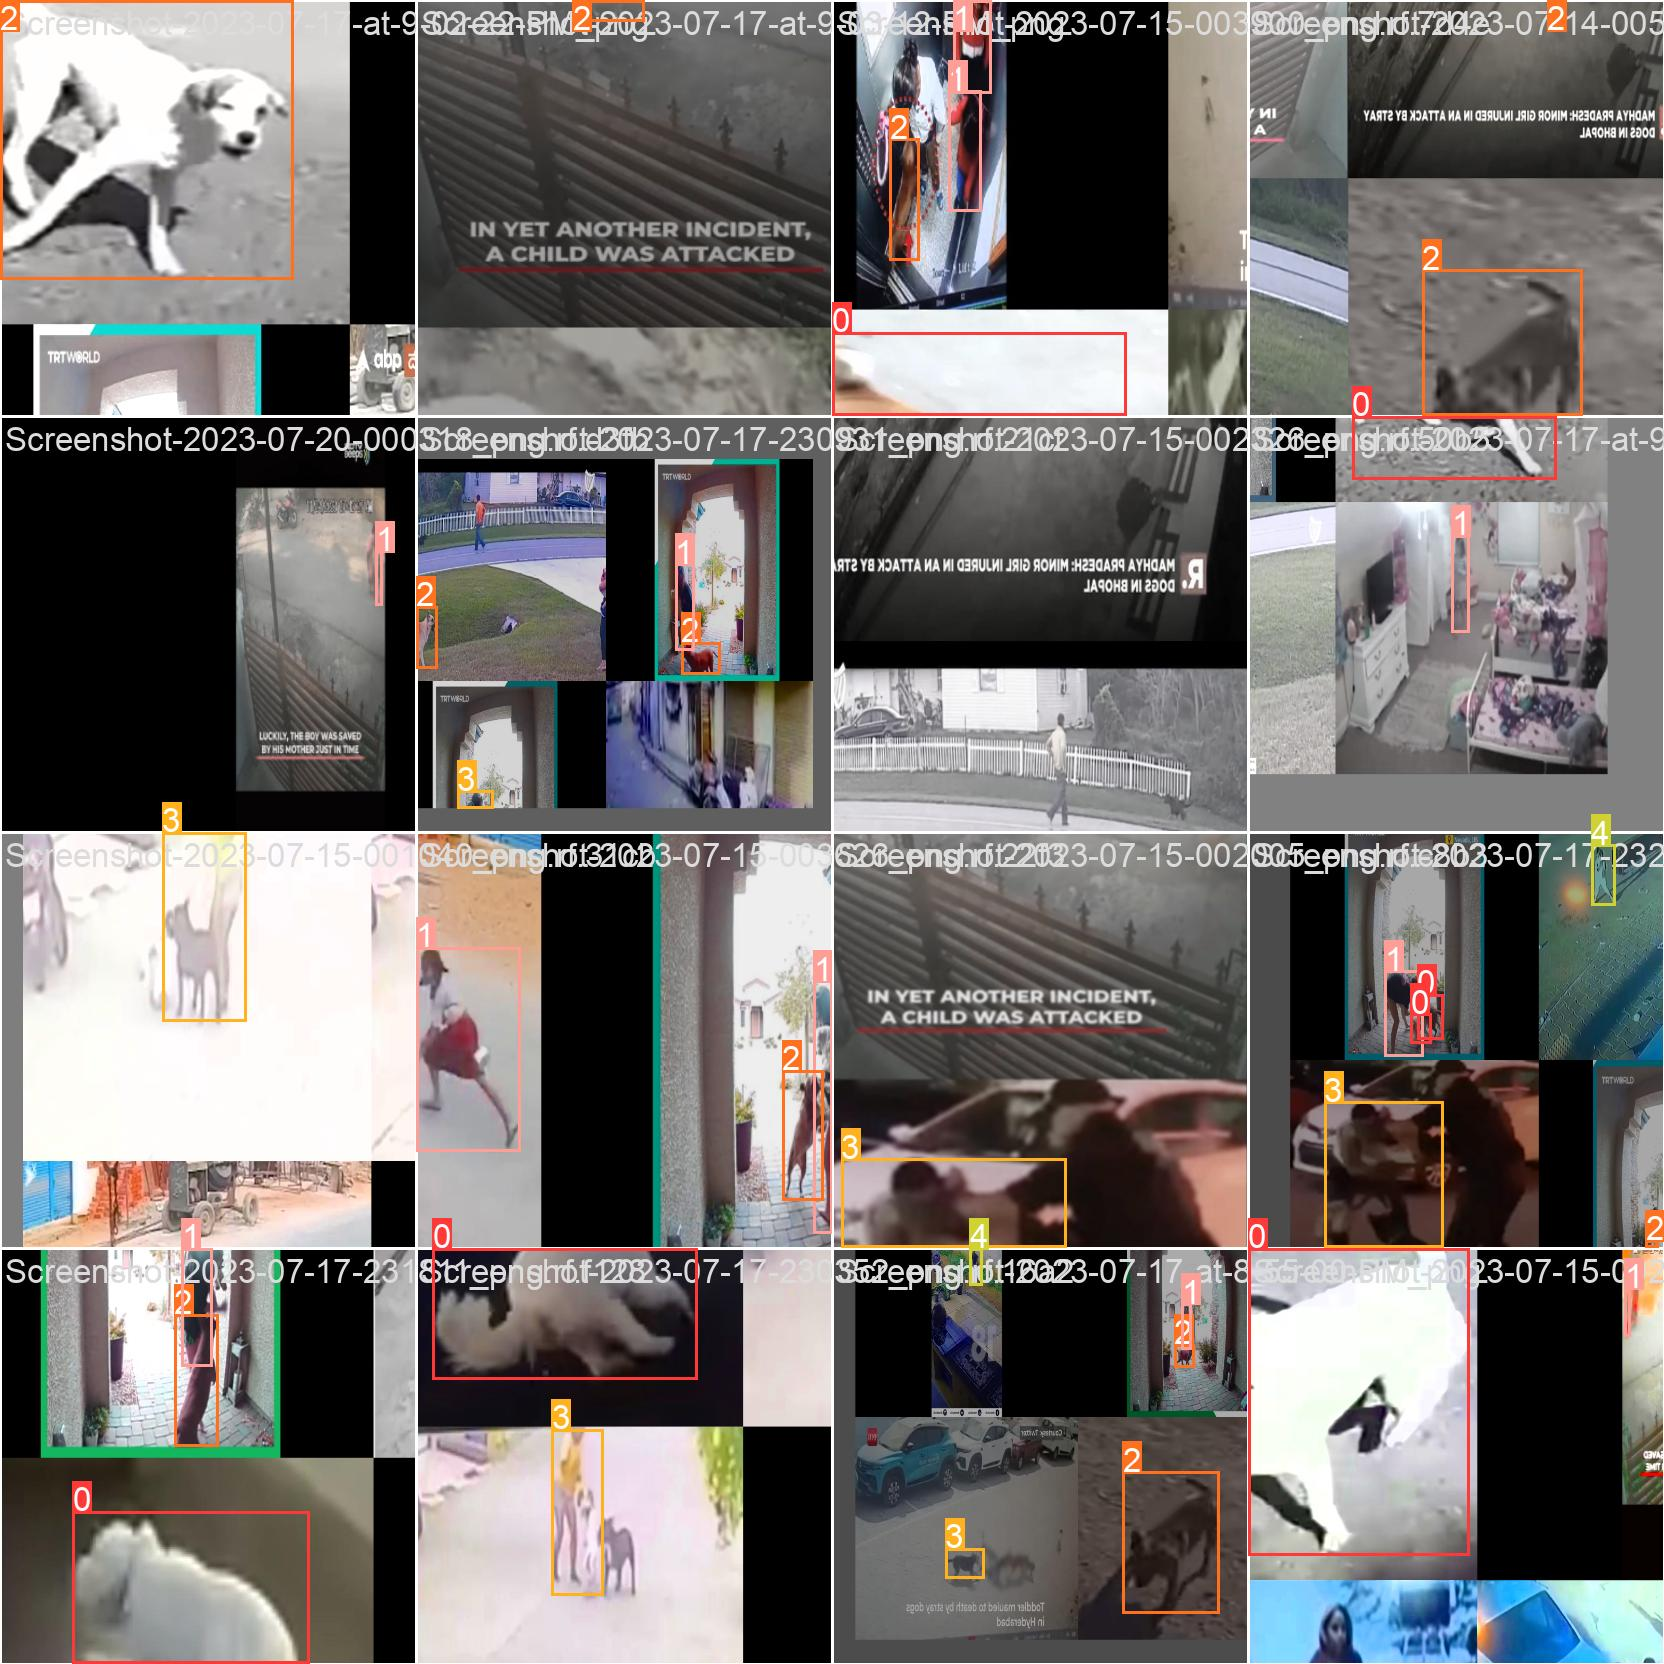

In [14]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [15]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [16]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [17]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7257306 parameters, 0 gradients
image 1/24 /content/test/images/Screenshot-2023-07-12-214121_png.rf.9512a02d395ff69620fa972fff502c48.jpg: 416x416 (no detections), 8.0ms
image 2/24 /content/test/images/Screenshot-2023-07-13-222325_png.rf.98ae0673922e0a39f75de496583f6371.jpg: 416x416 1 dog biting child, 8.1ms
image 3/24 /content/test/images/Screenshot-2023-07-1

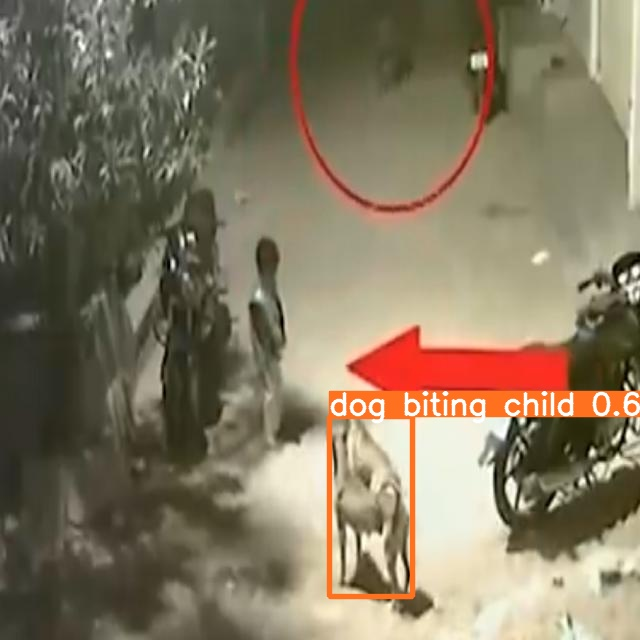

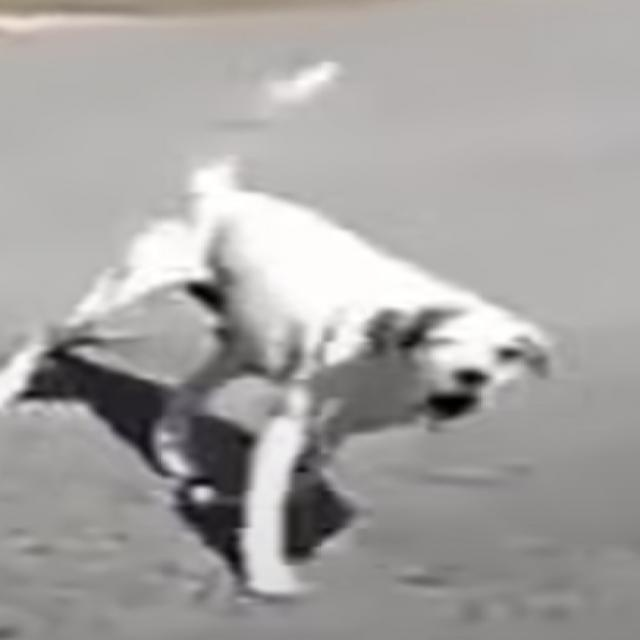

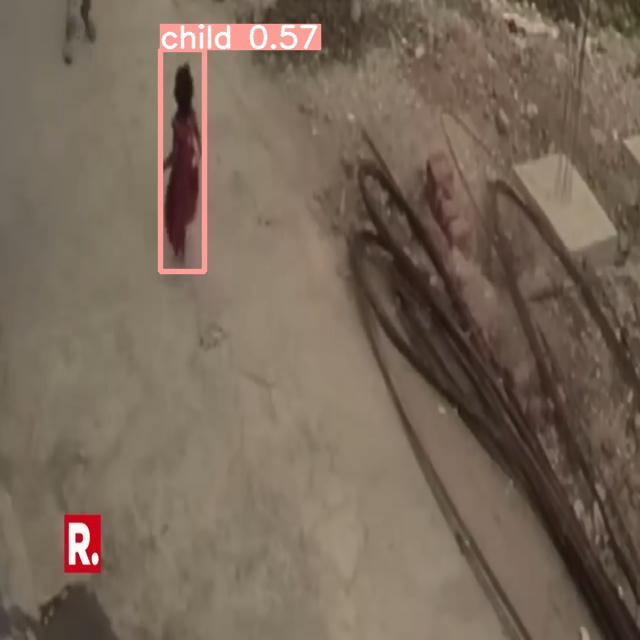

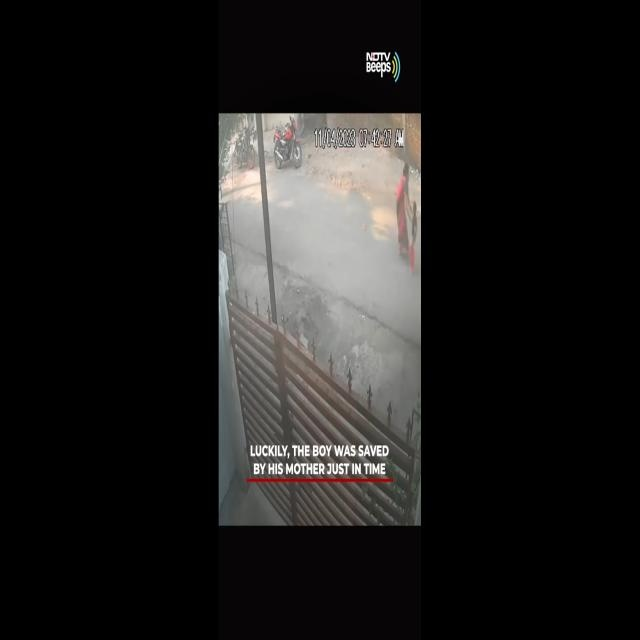

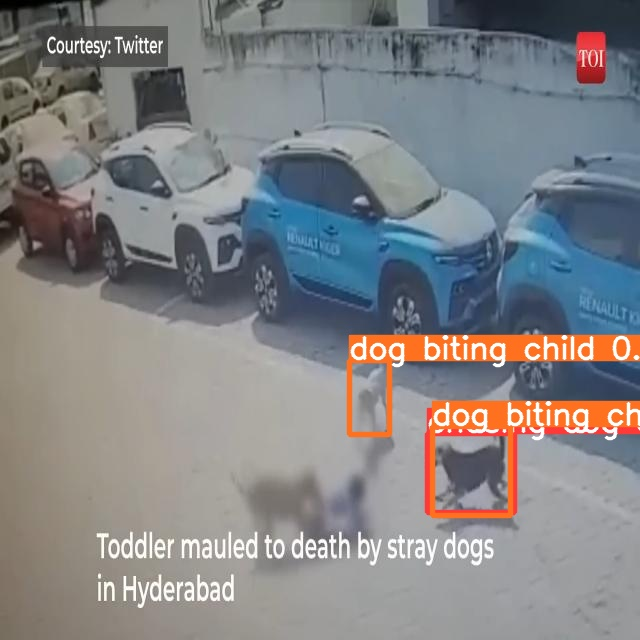

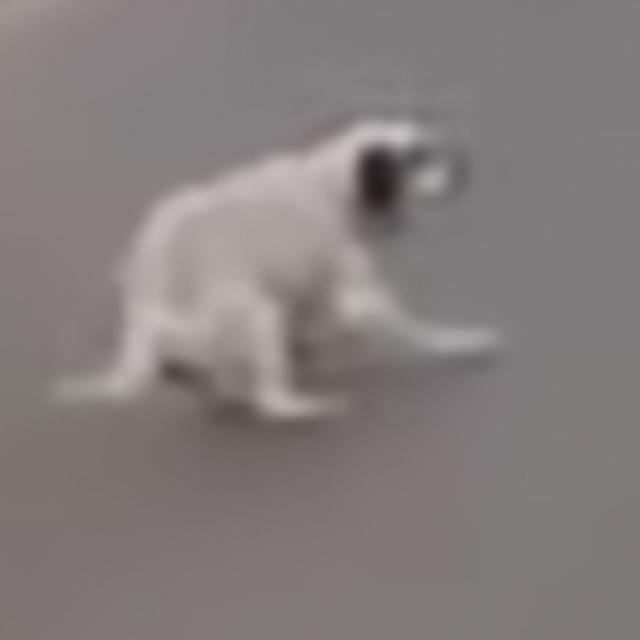

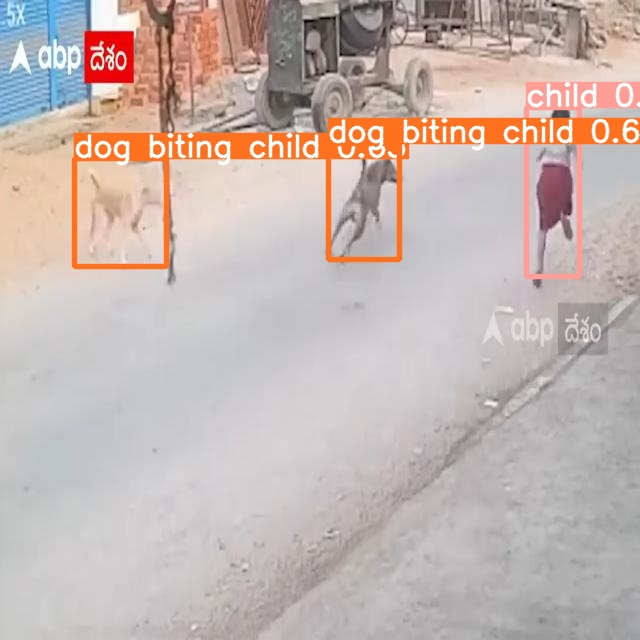

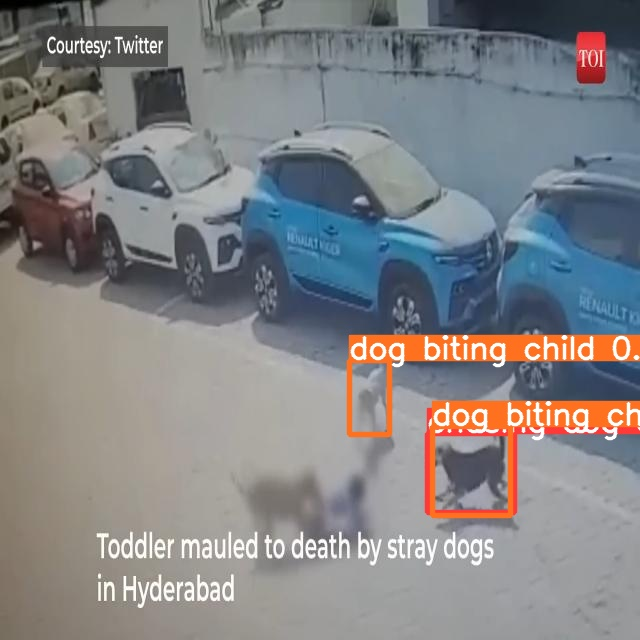

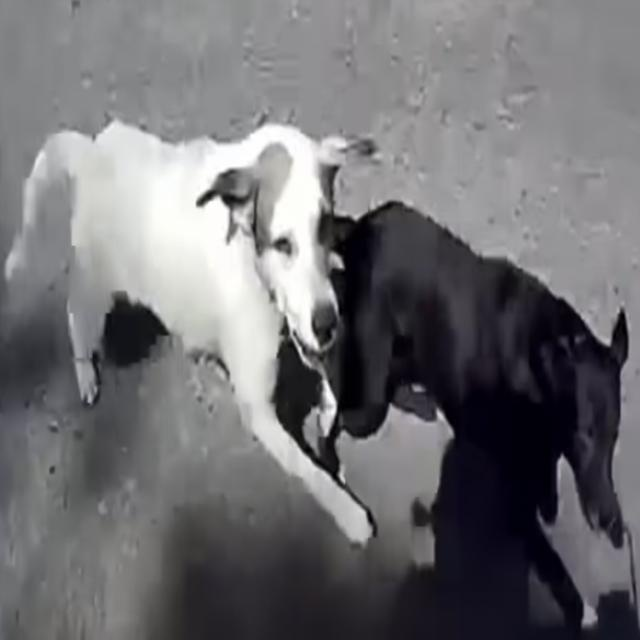

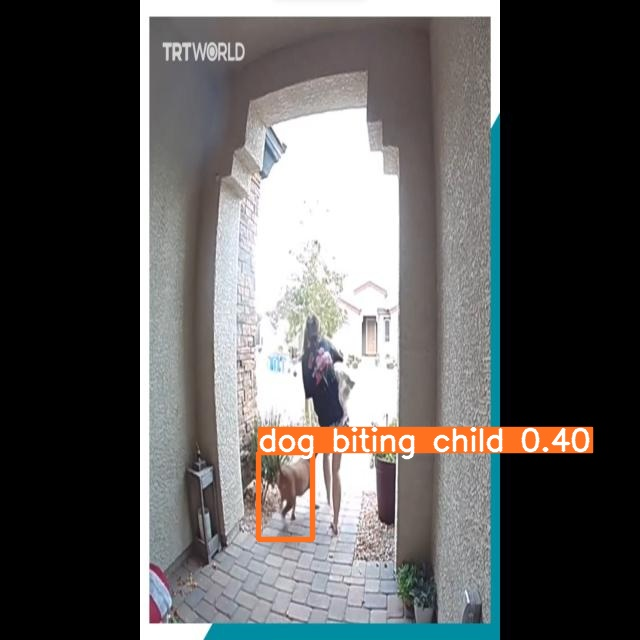

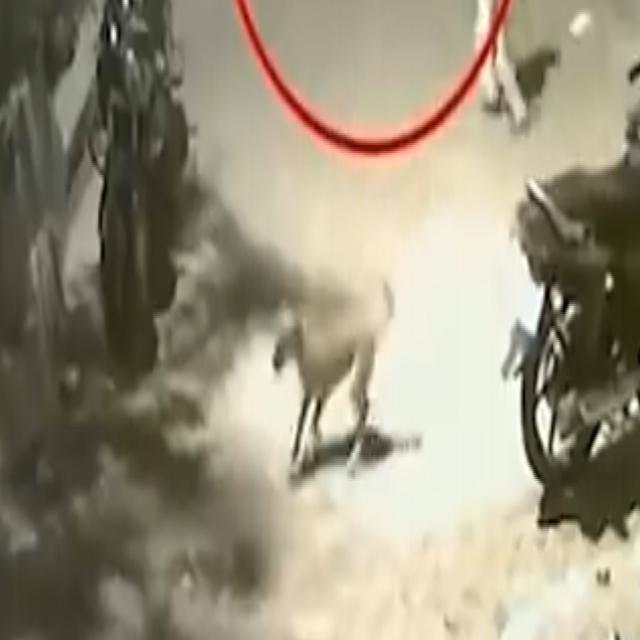

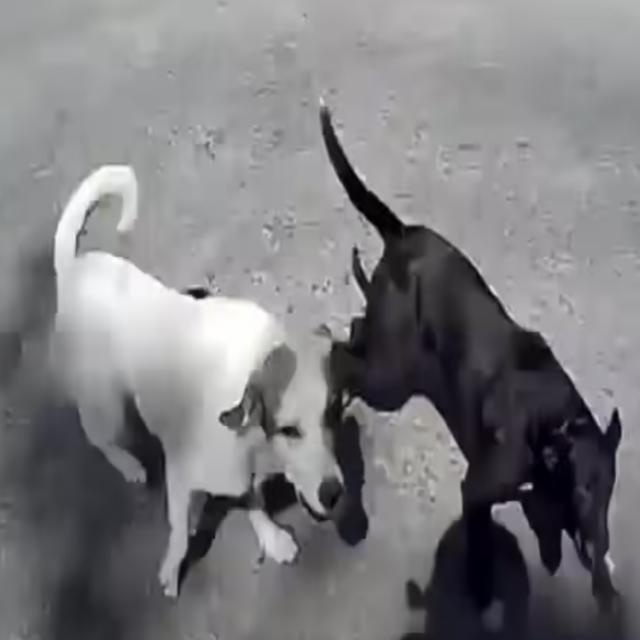

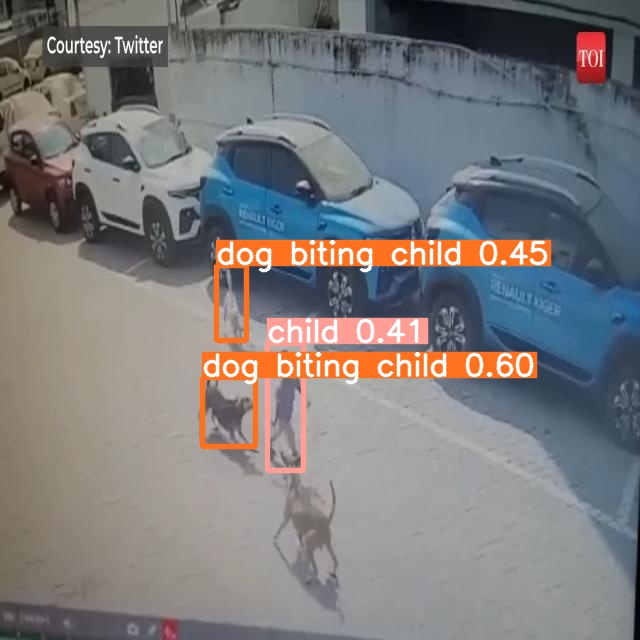

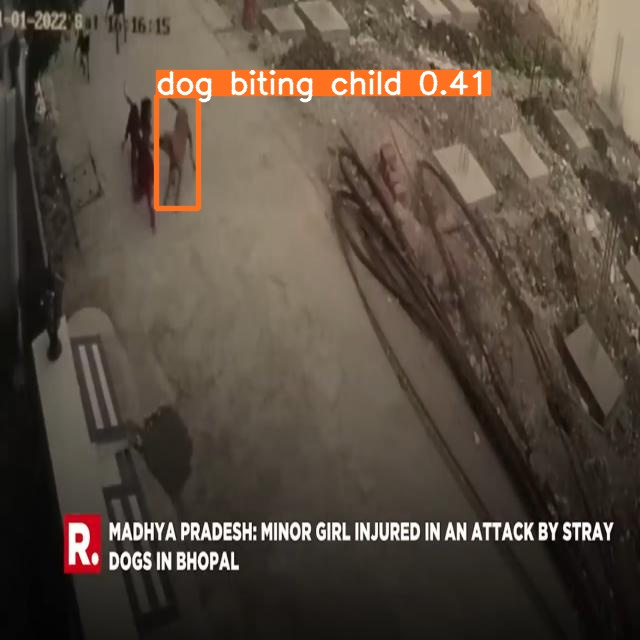

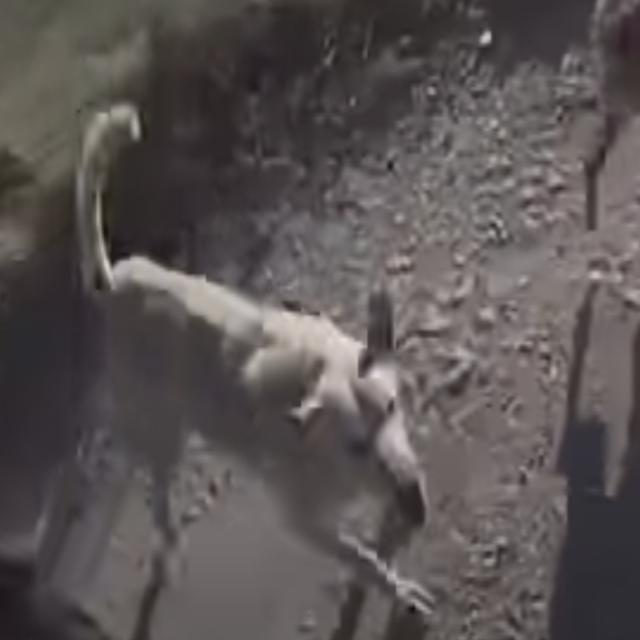

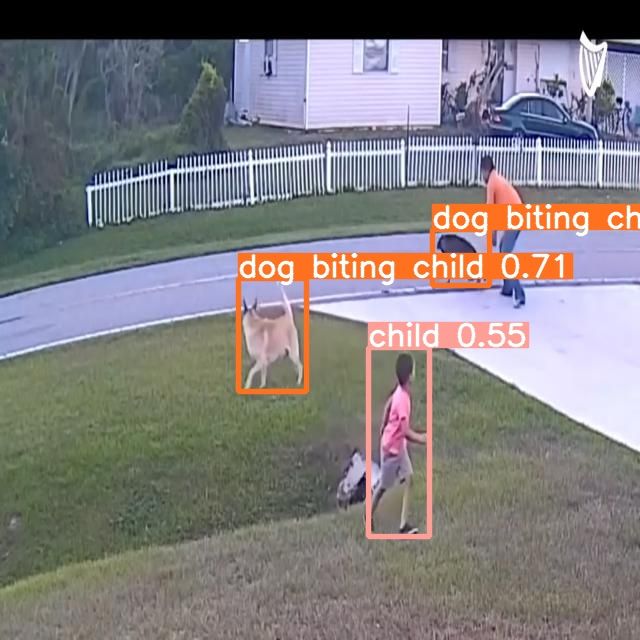

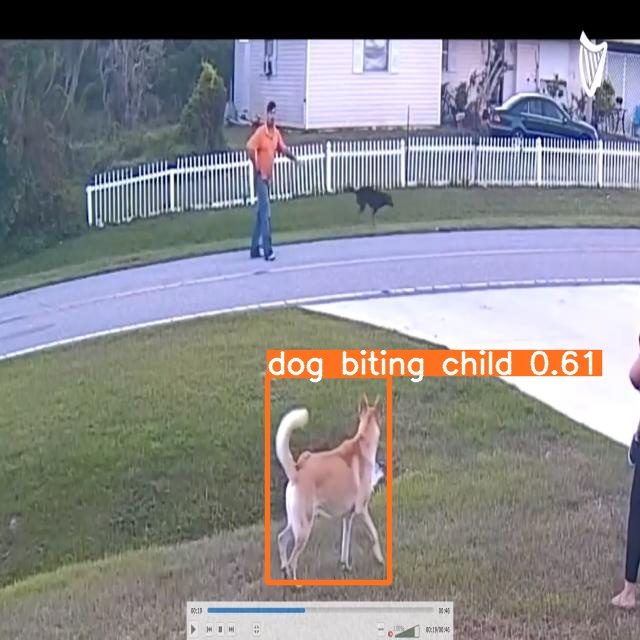

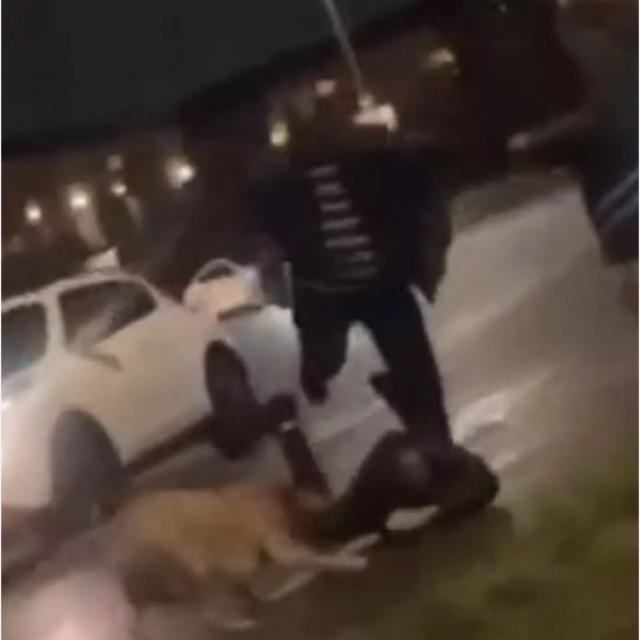

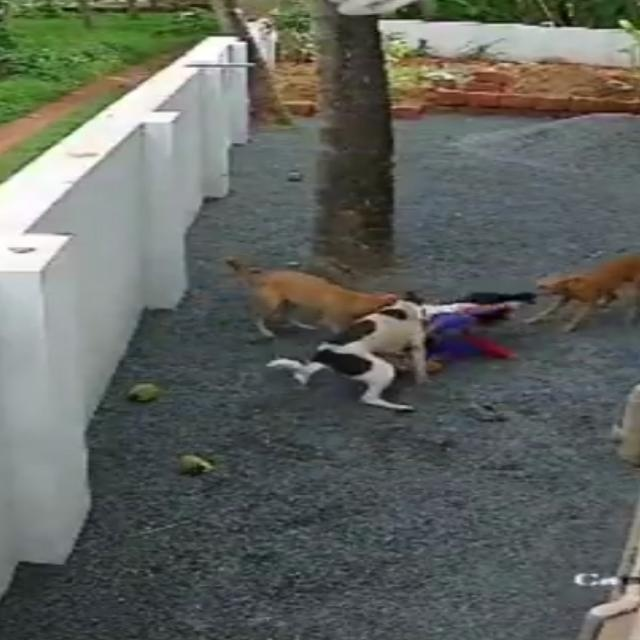

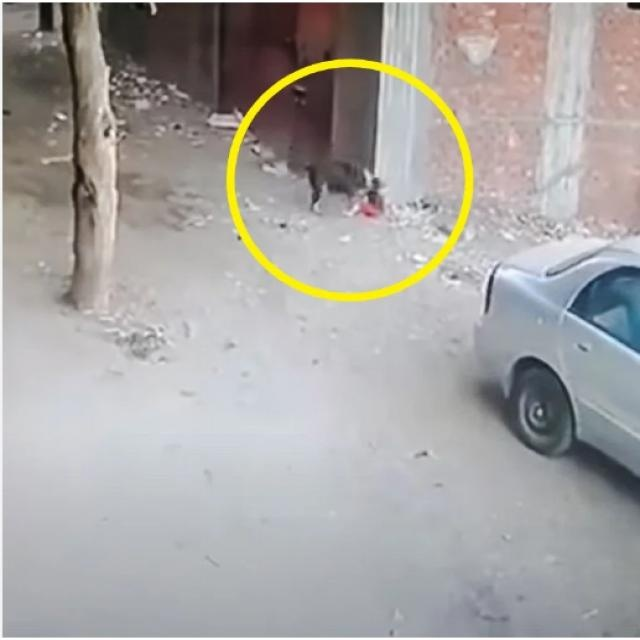

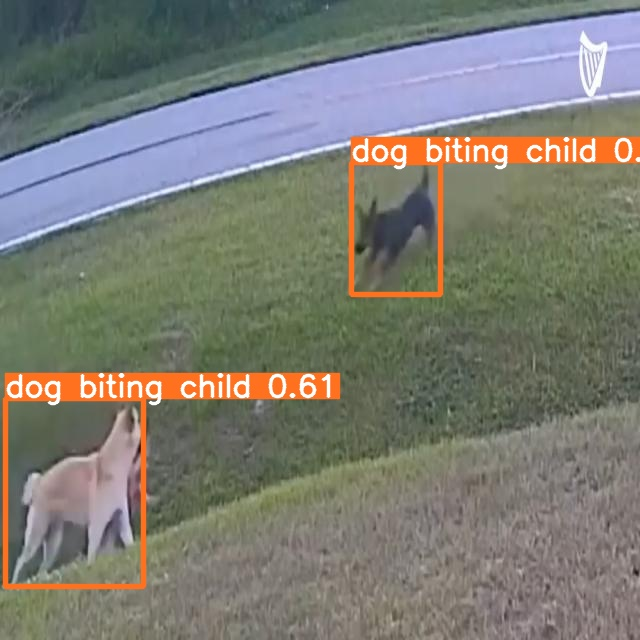

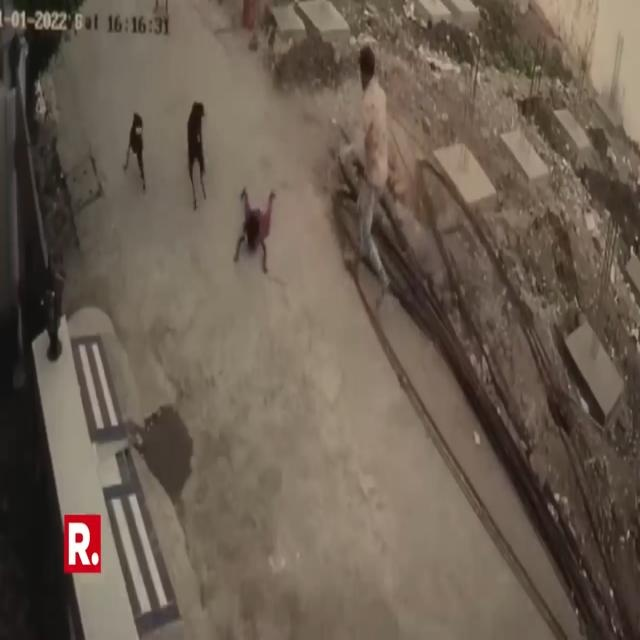

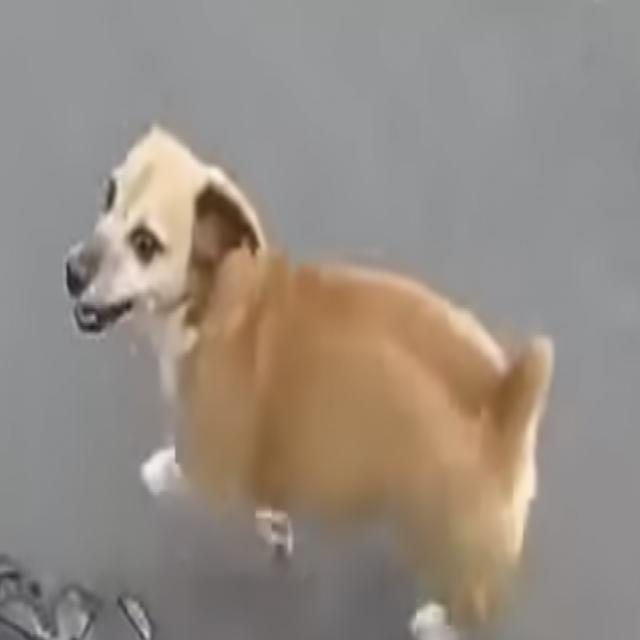

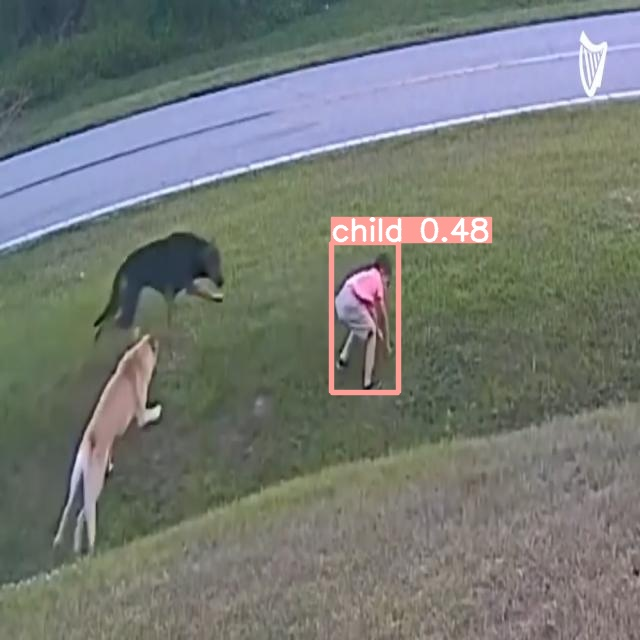

In [18]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [19]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.25 --source ../video4.mp4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../video4.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7257306 parameters, 0 gradients
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5

# Deploy Model Weights to Roboflow

Now that you have trained your custom detector, you can upload it to Roboflow to deploy you model to a Hosted API and edge containers.

In [20]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --include tflite --int8 --img 416 --data dataset.yaml

usage: detect.py
       [-h]
       [--weights WEIGHTS [WEIGHTS ...]]
       [--source SOURCE]
       [--data DATA]
       [--imgsz IMGSZ [IMGSZ ...]]
       [--conf-thres CONF_THRES]
       [--iou-thres IOU_THRES]
       [--max-det MAX_DET]
       [--device DEVICE]
       [--view-img]
       [--save-txt]
       [--save-conf]
       [--save-crop]
       [--nosave]
       [--classes CLASSES [CLASSES ...]]
       [--agnostic-nms]
       [--augment]
       [--visualize]
       [--update]
       [--project PROJECT]
       [--name NAME]
       [--exist-ok]
       [--line-thickness LINE_THICKNESS]
       [--hide-labels]
       [--hide-conf]
       [--half]
       [--dnn]
       [--vid-stride VID_STRIDE]
detect.py: error: unrecognized arguments: --include tflite --int8


In [ ]:
from google.colab import files

files.download('/content/yolov5/runs/train/yolov5s_results/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !cp /content/yolov5/runs/train/yolov5s_results/weights /content/custom_model_lite
# !cp /content/test /content/custom_model_lite
# !cp /content/train /content/custom_model_lite
# !cp /content/valid /content/custom_model_lite
# !cp /content/data.yaml /content/custom_model_lite

%cd /content
!zip -r custom_model_lite.zip custom_model_lite
!zip -r custom_model_lite.zip custom_model_lite

cp: -r not specified; omitting directory '/content/yolov5'
cp: -r not specified; omitting directory '/content/test'
cp: -r not specified; omitting directory '/content/train'
cp: -r not specified; omitting directory '/content/valid'
/content
  adding: custom_model_lite (deflated 42%)


In [ ]:
project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/content/yolov5/runs/train/yolov5s_results/")

In [ ]:
detect.save('/content/yolov5/runs/train/yolov5s_results/weights/hybridmodel.h5')

NameError: ignored

In [ ]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)